In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

In [2]:
def create_data():
    counter=0
    images = []
    labels=[]
    print('converting images...')
    for img in os.listdir('data'):
        images.append(np.asarray(PIL.Image.open('data/'+img).resize((64,64)).convert('L')).reshape(64,64,1))
        labels.append(img.split('.')[0])
        counter+=1
    images = np.asarray(images).astype('float32')
    display.clear_output(wait=True)
    print('done converting')
  #do something similar for the labels
    return images    

In [3]:
images=create_data()

done converting


In [4]:
images = (images - 127.5) / 127.5
BUFFER_SIZE = 142
BATCH_SIZE = 16

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = tf.keras.layers.Dense(4*4*512, use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        
        self.conv1 = tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        
        self.conv4 = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm5 = tf.keras.layers.BatchNormalization()

        self.conv5 = tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False)

    def call(self, x, training=True):
        x = self.fc1(x)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = tf.reshape(x, shape=(-1, 4, 4, 512))

        x = self.conv1(x)
        x = self.batchnorm2(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv2(x)
        x = self.batchnorm3(x, training=training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv3(x)
        x = self.batchnorm4(x, training=training)
        x = tf.nn.leaky_relu(x) 
        
        x = self.conv4(x)
        x = self.batchnorm5(x, training=training)
        x = tf.nn.leaky_relu(x) 

        x = tf.nn.tanh(self.conv5(x))  
        return x

In [11]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        
        self.conv2= tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        
        self.conv3= tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        
        self.conv4= tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')
        
        self.conv5= tf.keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')
        
        self.dropout = tf.keras.layers.Dropout(0.3)
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.fc1 = tf.keras.layers.Dense(1)

    def call(self, x, training=True):
        x = tf.nn.leaky_relu(self.conv1(x))
        x = self.dropout(x, training=training)
        
        x = tf.nn.leaky_relu(self.conv2(x))
        x = self.dropout(x, training=training)
        
        x = tf.nn.leaky_relu(self.conv3(x))
        x = self.dropout(x, training=training)
        
        x = tf.nn.leaky_relu(self.conv4(x))
        x = self.dropout(x, training=training)
        
        x = tf.nn.leaky_relu(self.conv5(x))
        x = self.dropout(x, training=training)
        
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [20]:
generator = Generator()
discriminator = Discriminator()

In [21]:
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

In [22]:
def discriminator_loss(real_output, generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output)*(0.8), logits=real_output)

    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output)*(0.1), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [23]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [24]:
discriminator_optimizer = tf.train.AdamOptimizer(0.00005, beta1=0.5)
generator_optimizer = tf.train.AdamOptimizer(0.0002, beta1=0.5)

In [32]:
checkpoint_dir = 'checkpoint/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [3]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 1

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [53]:
def generate_and_save_images(model, epoch):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
    predictions = model(random_vector_for_generation, training=False)
    e2=predictions*127.5+127.5
#     fig = plt.figure(figsize=(4,4))
        
#       for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#         plt.axis('off')
        
#     plt.savefig('img2/image_at_epoch_{:04d}.png'.format(epoch))
    yo=PIL.Image.fromarray(np.uint8(e2[0]))
    return yo.resize((100,100))

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [36]:
def train(dataset, epochs, noise_dim):  
    for epoch in range(epochs):
        start = time.time()
    
        for images in dataset:
          # generating noise from a uniform distribution
            noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)
      
                real_output = discriminator(images, training=True)
                generated_output = discriminator(generated_images, training=True)
        
                gen_loss = generator_loss(generated_output)
                disc_loss = discriminator_loss(real_output, generated_output)
            
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

      
        if epoch % 1 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                               epoch + 1)
    
    # saving (checkpoint) the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                           epochs)

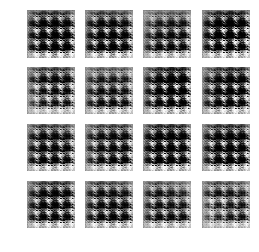

KeyboardInterrupt: 

In [174]:
train(train_dataset, EPOCHS, noise_dim)

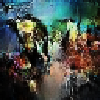

In [51]:
generate_and_save_images(generator,200)

In [38]:
tf.train.latest_checkpoint(checkpoint_dir)

'checkpoint/ckpt-99'

In [15]:
Discriminator().call(tf.random_normal([1,128,128,3]))

<tf.Tensor: id=1250, shape=(1, 1), dtype=float32, numpy=array([[0.00658948]], dtype=float32)>